The aim of this notebook is to analysis the content of the file *suivi gainz*. To provide a better understanding and extract useful insights from the data collected in the most automated way as possible. There are for the moment 2 main topics to analysis and extract informations from in the file:
1. Evolution of weights and repetitions
2. Synthesis of comments

# Evolution of weights and repetitions

For each workout tab (ex: *pull* tab). We want to:
1. **Follow the evolution of weights, repetitions and executions** (via the comments)
2. **Provide insights on what muscles have been trained** based on different time period. (ex: last week how many time did I train biceps? Over the last 6 months how many sets have I done on traps? etc)
3. **Provide insights on how muscles have been trained**. (ex: I know I did X sets of X exercise on a muscle. How did the training go? Were there exercises that also impacted this muscle indirectly?)

In [1]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

In [2]:
# Charger le fichier Excel
file_path = '~/Documents/Dev Projects/Workout Analysis/data training/suivi gainz (1).xlsx'
xls = pd.ExcelFile(file_path)

# Charger la feuille 'pull prog 37-41'
pull_prog_data = pd.read_excel(xls, sheet_name='pull prog 37-41')

In [3]:
def rename_columns_by_week(df):
    # Start renaming from the 3rd column
    for i in range(2, df.shape[1], 3): #Skip the 2 first columns and work by groups of 3
        # Use the name of the first column in the group as the week indicator 
        week_indicator = pull_prog_data.columns[i]
        
        pull_prog_data.rename(columns={
                'Unnamed: 0': 'Exercise',
                'Unnamed: 1': 'Series',
                pull_prog_data.columns[i+2]: f'{week_indicator}_{pull_prog_data.iloc[0, i+2]}',
                pull_prog_data.columns[i+1]: f'{week_indicator}_{pull_prog_data.iloc[0, i+1]}',
                pull_prog_data.columns[i]: f'{week_indicator}_{pull_prog_data.iloc[0, i]}'
            }, inplace=True)
    
    # Drop the first row if it's no longer needed
    df = df.drop(index=0).reset_index(drop=True)
    
    # Add exercise name for each series 
    df['Exercise'] = df['Exercise'].ffill()

    # Gestion des dates à prévoir plus tard
    df = df.drop([0, 1])
    # Gestion des séances manquées
    df = df.fillna(0)

    return df

In [4]:
new_df = rename_columns_by_week(pull_prog_data)
df = new_df

/var/folders/35/ytf2n9bj7qbc9clbjpvgcgxr0000gn/T/ipykernel_18230/3059957856.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


In [6]:
test = df[df['Exercise'] == 'biceps cable ']

In [18]:
data = test

In [36]:
# Préparation des données pour les semaines
def prepare_data(data):
    # Création d'une liste pour stocker les données transformées
    processed_data = []
    # Filtrer les colonnes de poids, répétitions, et commentaires pour chaque semaine
    weeks = sorted(set(col.split('_')[0] for col in data.columns if 'weight' in col))

    for _, row in data.iterrows():
        for week in weeks:
            weight_col = f"{week}_weight"
            reps_col = f"{week}_reps"
            # Vérifier la présence de valeurs pour le poids et les répétitions
            if weight_col in data.columns and reps_col in data.columns:
                processed_data.append({
                    'Series': row['Series'],
                    'Week': week,
                    'Weight': row[weight_col],
                    'Reps': row[reps_col]
                })
    
    return pd.DataFrame(processed_data)

In [31]:
# Convertir le DataFrame
plot_data = prepare_data(data)

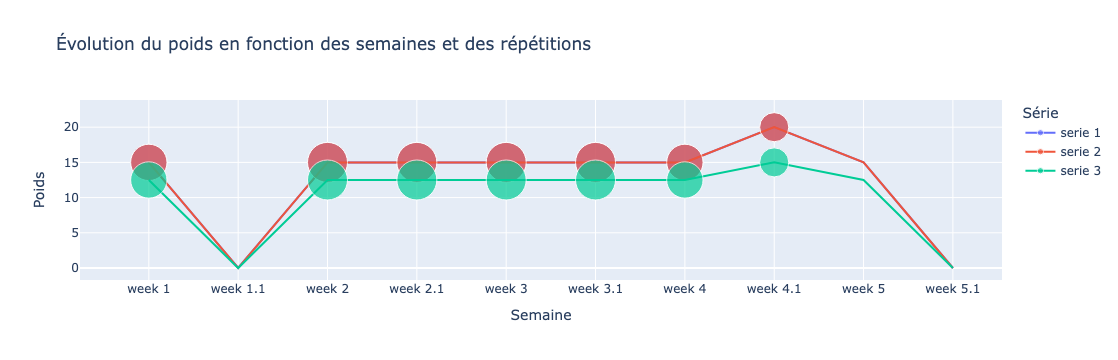

In [35]:
# Créer le graphique interactif avec des lignes pour connecter les points
fig = px.line(
    plot_data,
    x="Week",
    y="Weight",
    color="Series",
    line_shape="linear",
    title="Évolution du poids en fonction des semaines et des répétitions",
    labels={"Weight": "Poids", "Week": "Semaine", "Reps": "Répétitions", "Series": "Série"},
)

# Ajouter les points avec une taille dépendante des répétitions
fig.update_traces(mode="lines+markers")
fig.update_traces(marker=dict(sizemode='diameter', sizeref=max(plot_data['Reps'])/40, sizemin=4), 
                  marker_size=plot_data['Reps'])

fig.update_layout(autosize=True)
fig.show()